# Biases of TOA radiative fluxes btw CNRM-CM6-1 PPE and CERES dataset 
Here we want to estimate the biases in TOA radiative fluxes (SW, LW and Net) between the members of CNRM-CM6-1 PPE and the CERES observation dataset. The idea is to get metrics assessing the skill of the models, especially in regard of the feedbacks in these models.

# Importe modules

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas

# Plotting modules 
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns

# Functions definition

In [2]:
import sys
sys.path.append('/data/home/globc/peatier/CNRMppe')
import Fonctions
from Fonctions import get_wavg_budget_df
from Fonctions import wavg 
from Fonctions import plotlines_Xdf
from Fonctions import plotlines_1df
from Fonctions import Deltas_Lambda

# Read files : radiative budget, tas

## Observations CERES

In [3]:
def load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df=file[variables].to_dataframe()
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon'])
    df1['month']=pd.DatetimeIndex(df1['time']).month # time in years
    df_mean=df1.groupby(['month', 'lat', 'lon']).mean()
    
    return df_mean

In [4]:
#...................................................................
# GLOBAL MEAN WEIGHTED WITH COS(LAT)

import xarray as xr
import numpy as np
import pandas as pd


def wavg(df, start_yr, variables):
    # First, we need to convert latitude to radians and the time into year
    df1=df.reset_index(level=['month', 'lat'])
    df1['latr'] = np.deg2rad(df1['lat']) # lat in radians 


    # Then, we find the zonal mean by averaging along the latitude circles
    df2=df1.groupby(['month', 'lat']).mean()

    # Finally, we use the cosine of the converted latitudes as weights for the average
    df2['weights'] = np.cos(df2['latr'])
    result=pd.DataFrame()
    df2_tmp=df2.groupby(['month']).mean()
    result[variables]=df2_tmp[variables]
    N=len(result)
    YR=start_yr
    i=0
    while i < N:
        yr=YR+i
        tmp=df2.loc[yr]
        n=len(variables)
        j=0
        while j < n:
            t = (tmp[variables[j]]*tmp['weights']).sum()/tmp['weights'].sum()
            result[variables[j]].iloc[i]=t
            j = j + 1
        i = i + 1

    #r = result.mean()
    return result

In [5]:
path_observation = '/data/home/globc/peatier/obs_data/'
filename = 'CERES_EBAF-TOA_Ed4.1_Subset_200003-201910_regrid.nc'
    
# Load data and compute Annual Cycle :
file = xr.open_mfdataset(path_observation+filename,combine='by_coords')
#file
variables = ['toa_sw_all_mon','toa_lw_all_mon', 'toa_net_all_mon']
df_obs = load_monthly_clim(path_observation, filename, variables)#.to_xarray()
#df_global = wavg(df, 1, variables).to_xarray()
df_obs

toa_sw_all_mon  toa_lw_all_mon  toa_net_all_mon
month lat        lon                                                       
1     -88.927735 0.00000        344.953522      189.246185       -38.599289
                 1.40625        344.953522      189.246185       -38.599289
                 2.81250        344.953522      189.246185       -38.599289
                 4.21875        344.992493      189.144440       -38.531315
                 5.62500        345.007721      189.104630       -38.504715
...                                    ...             ...              ...
12     88.927735 352.96875        0.000000      171.476639      -171.476639
                 354.37500        0.000000      171.476639      -171.476639
                 355.78125        0.000000      171.500351      -171.500351
                 357.18750        0.000000      171.560974      -171.560974
                 358.59375        0.000000      171.560974      -171.560974

[393216 rows x 3 columns]

## Second PPE : amip and amip-future4K

In [6]:
path_official = '/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE = '/data/scratch/globc/peatier/CNRM-CM6-1_PPE/ENSEMBLE2/'
path_p1 = '/data/scratch/globc/peatier/CNRM-CM6-1_PPE/ENSEMBLE1/'
variables = ['rlut', 'rsut','rsdt','tas']

path = path_p1+'/CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p1f2/'
filename = '*_CNRM-CM6-1_amip_*.nc'
official_amip = load_monthly_clim(path, filename, variables)
#official_amip


official_amip['SW'] = official_amip['rsdt'] - official_amip['rsut']
official_amip['N'] = official_amip['SW'] - official_amip['rlut']
official_amip

rlut        rsut        rsdt         tas  \
month lat        lon                                                         
1     -88.927735 0.00000    181.814178  366.411407  497.343781  244.287369   
                 1.40625    181.814178  366.411407  497.343781  244.287369   
                 2.81250    181.814178  366.411407  497.343781  244.287369   
                 4.21875    181.814178  366.411407  497.343781  244.287369   
                 5.62500    181.814178  366.411407  497.343781  244.287369   
...                                ...         ...         ...         ...   
12     88.927735 352.96875  168.578278    0.000000    0.000000  245.409012   
                 354.37500  168.578278    0.000000    0.000000  245.409012   
                 355.78125  168.578278    0.000000    0.000000  245.409012   
                 357.18750  168.578278    0.000000    0.000000  245.409012   
                 358.59375  168.578278    0.000000    0.000000  245.409012   

                            height          SW           N  
month lat        lon                                        
1     -88.927735 0.00000       2.0  130.932373  -50.881805  
                 1.40625       2.0  130.932373  -50.881805  
                 2.81250       2.0  130.932373  -50.881805  
                 4.21875       2.0  130.932373  -50.881805  
                 5.62500       2.0  130.932373  -50.881805  
...                            ...         ...         ...  
12     88.927735 352.96875     2.0    0.000000 -168.578278  
                 354.37500     2.0    0.000000 -168.578278  
                 355.78125     2.0    0.000000 -168.578278  
                 357.18750     2.0    0.000000 -168.578278  
                 358.59375     2.0    0.000000 -168.578278  

[393216 rows x 7 columns]

In [7]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/CNRM-CM6-1_PPE/ENSEMBLE2/'
variables = ['rlut', 'rsut','rsdt','tas']

# The amip experiments, new ensemble LHS500 : 

start_yr=1979
drop=False
year_list=None
nb_p_list_LHS500 = ['p311', 'p312', 'p314', 'p316',
                    'p317', 'p319', 'p320', 'p321', 'p322', 'p324', 'p325', 'p326', 
                    'p329', 'p330', 'p331', 'p332', 'p335', 'p336', 'p337' ,'p338', 
                    'p340', 'p341', 'p343', 'p344', 'p346', 'p347', 'p348', 'p349', 
                    'p350', 'p353', 'p355', 'p357', 'p359', 'p360', 
                    'p361', 'p363', 'p365', 'p367', 'p368', 'p369', 
                    'p372', 'p373', 'p374', 'p375', 'p376', 'p378', 'p381', 'p382', 
                    'p384', 'p386', 'p388', 'p389', 'p391', 'p392', 'p393', 
                    'p394', 'p395', 'p396', 'p398', 'p399', 'p400', 'p404', 
                    'p406', 'p407', 'p409', 'p410', 'p411', 'p412',
                    'p414','p416',
                    'p413','p419','p424','p426','p428','p421','p423',
                    'p425','p427','p429','p430','p436','p438','p431','p433',
                    'p442','p446','p443','p445','p447',
                    'p452','p454','p456','p458','p457','p459',
                    'p460','p465','p467','p469',
                    'p470','p471']
N=len(nb_p_list_LHS500)
amip_LHS500={}
i = 0
while i<N:
    nb_p_LHS500 = nb_p_list_LHS500[i]
    print(nb_p_LHS500)
    path=path_PPE+'CNRM-CM6-1_amip_LHS500_PPE/CNRM-CM6-1_amip_r1i1'+nb_p_LHS500+'f2/'
    filename = '*_CNRM-CM6-1_amip_r1i1'+nb_p_LHS500+'f2*.nc'
    amip_LHS500[str(nb_p_LHS500) + "_amip"] = load_monthly_clim(path, filename, variables)
    #amip_LHS500[str(nb_p_LHS500) + "_amip"] = wavg(tmp, 1, variables)
    i=i+1
    

p311
p312
p314
p316
p317
p319
p320
p321
p322
p324
p325
p326
p329
p330
p331
p332
p335
p336
p337
p338
p340
p341
p343
p344
p346
p347
p348
p349
p350
p353
p355
p357
p359
p360
p361
p363
p365
p367
p368
p369
p372
p373
p374
p375
p376
p378
p381
p382
p384
p386
p388
p389
p391
p392
p393
p394
p395
p396
p398
p399
p400
p404
p406
p407
p409
p410
p411
p412
p414
p416
p413
p419
p424
p426
p428
p421
p423
p425
p427
p429
p430
p436
p438
p431
p433
p442
p446
p443
p445
p447
p452
p454
p456
p458
p457
p459
p460
p465
p467
p469
p470
p471


In [8]:
PPE = {}
for i in nb_p_list_LHS500 :
    df = amip_LHS500[str(i) + "_amip"]
    df['SW'] = df['rsdt'] - df['rsut']
    df['N'] = df['SW'] - df['rlut']
    PPE[str(i)] = df#.to_xarray() 
    

In [9]:
PPE[str(i)]

rlut        rsut        rsdt         tas  \
month lat        lon                                                         
1     -88.927735 0.00000    181.292419  365.313385  497.452148  244.079025   
                 1.40625    181.292419  365.313385  497.452148  244.079025   
                 2.81250    181.292419  365.313385  497.452148  244.079025   
                 4.21875    181.292419  365.313385  497.452148  244.079025   
                 5.62500    181.292419  365.313385  497.452148  244.079025   
...                                ...         ...         ...         ...   
12     88.927735 352.96875  166.110687    0.000000    0.000000  241.448013   
                 354.37500  166.110687    0.000000    0.000000  241.448013   
                 355.78125  166.110687    0.000000    0.000000  241.448013   
                 357.18750  166.110687    0.000000    0.000000  241.448013   
                 358.59375  166.110687    0.000000    0.000000  241.448013   

                            height          SW           N  
month lat        lon                                        
1     -88.927735 0.00000       2.0  132.138763  -49.153656  
                 1.40625       2.0  132.138763  -49.153656  
                 2.81250       2.0  132.138763  -49.153656  
                 4.21875       2.0  132.138763  -49.153656  
                 5.62500       2.0  132.138763  -49.153656  
...                            ...         ...         ...  
12     88.927735 352.96875     2.0    0.000000 -166.110687  
                 354.37500     2.0    0.000000 -166.110687  
                 355.78125     2.0    0.000000 -166.110687  
                 357.18750     2.0    0.000000 -166.110687  
                 358.59375     2.0    0.000000 -166.110687  

[393216 rows x 7 columns]

## Compute biases

In [10]:
official_amip['bias_SW'] = official_amip['rsut'] - df_obs['toa_sw_all_mon']
official_amip['bias_LW'] = official_amip['rlut'] - df_obs['toa_lw_all_mon']
official_amip['bias_N'] = official_amip['N'] - df_obs['toa_net_all_mon']

variables = ['bias_SW','bias_LW','bias_N']
df = official_amip.abs()
Biases_official = wavg(df,1,variables).mean()
Biases_official

bias_SW    12.113443
bias_LW     7.806050
bias_N      9.862451
dtype: float64

In [11]:
for i in nb_p_list_LHS500 :
    print(i)
    amip_LHS500[str(i) + "_amip"]['bias_SW'] = amip_LHS500[str(i) + "_amip"]['rsut'] - df_obs['toa_sw_all_mon']
    amip_LHS500[str(i) + "_amip"]['bias_LW'] = amip_LHS500[str(i) + "_amip"]['rlut'] - df_obs['toa_lw_all_mon']
    amip_LHS500[str(i) + "_amip"]['bias_N'] = amip_LHS500[str(i) + "_amip"]['N'] - df_obs['toa_net_all_mon']

p311
p312
p314
p316
p317
p319
p320
p321
p322
p324
p325
p326
p329
p330
p331
p332
p335
p336
p337
p338
p340
p341
p343
p344
p346
p347
p348
p349
p350
p353
p355
p357
p359
p360
p361
p363
p365
p367
p368
p369
p372
p373
p374
p375
p376
p378
p381
p382
p384
p386
p388
p389
p391
p392
p393
p394
p395
p396
p398
p399
p400
p404
p406
p407
p409
p410
p411
p412
p414
p416
p413
p419
p424
p426
p428
p421
p423
p425
p427
p429
p430
p436
p438
p431
p433
p442
p446
p443
p445
p447
p452
p454
p456
p458
p457
p459
p460
p465
p467
p469
p470
p471


In [12]:
variables = ['bias_SW','bias_LW','bias_N']
Biases_globalAVG = {}
for i in nb_p_list_LHS500 :
    print(i)
    df = amip_LHS500[str(i) + "_amip"].abs()
    Biases_globalAVG[str(i)] = wavg(df,1,variables)

p311
p312
p314
p316
p317
p319
p320
p321
p322
p324
p325
p326
p329
p330
p331
p332
p335
p336
p337
p338
p340
p341
p343
p344
p346
p347
p348
p349
p350
p353
p355
p357
p359
p360
p361
p363
p365
p367
p368
p369
p372
p373
p374
p375
p376
p378
p381
p382
p384
p386
p388
p389
p391
p392
p393
p394
p395
p396
p398
p399
p400
p404
p406
p407
p409
p410
p411
p412
p414
p416
p413
p419
p424
p426
p428
p421
p423
p425
p427
p429
p430
p436
p438
p431
p433
p442
p446
p443
p445
p447
p452
p454
p456
p458
p457
p459
p460
p465
p467
p469
p470
p471


## Create plot

In [13]:
def plotlines_Xdf(df, y, title, colors, linewidth, xlabel, xmin, xmax, ymin, ymax):
    ax_model=plt.gca()
    N=len(df)
    i=0
    while i < N:
        df[i].plot(y=y,kind='line',title=title,legend=False, color=colors[i],linewidth=linewidth[i],ax=ax_model)
        i = (i+1)

    plt.xlabel(xlabel)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    #ax_model.legend(legend, loc='center left', bbox_to_anchor=(1, 0.5))

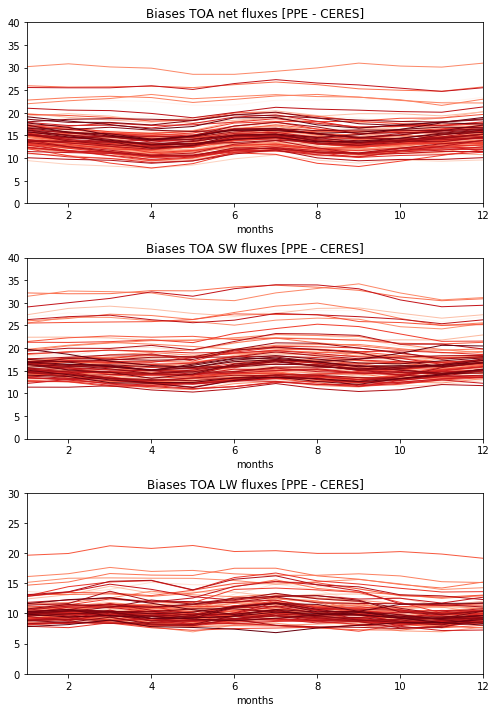

In [14]:
n = len(nb_p_list_LHS500)
df = [None]*n
df[:] = [Biases_globalAVG[str(i)]for i in nb_p_list_LHS500]

# Plot of lines from different dataframes
plt.subplots(figsize=(7,10)) 

plt.subplot(311)
title = 'Biases TOA net fluxes [PPE - CERES]'
y = 'bias_N'
ymin = 0.0
ymax = 40.0
cmap2 = plt.get_cmap('Reds')
colors = [cmap2(i) for i in np.linspace(0, 1, len(nb_p_list_LHS500))]
linewidth = [1.0]*n
xmin = 1.0
xmax = 12.0
xlabel='months'
plotlines_Xdf(df, y, title, colors, linewidth, xlabel, xmin, xmax, ymin, ymax)

plt.subplot(312)
title = 'Biases TOA SW fluxes [PPE - CERES]'
y = 'bias_SW'
ymin = 0.0
ymax = 40.0
cmap2 = plt.get_cmap('Reds')
colors = [cmap2(i) for i in np.linspace(0, 1, len(nb_p_list_LHS500))]
linewidth = [1.0]*n
xmin = 1.0
xmax = 12.0
xlabel='months'
plotlines_Xdf(df, y, title, colors, linewidth, xlabel, xmin, xmax, ymin, ymax)

plt.subplot(313)
title = 'Biases TOA LW fluxes [PPE - CERES]'
y = 'bias_LW'
ymin = 0.0
ymax = 30.0
cmap2 = plt.get_cmap('Reds')
colors = [cmap2(i) for i in np.linspace(0, 1, len(nb_p_list_LHS500))]
linewidth = [1.0]*n
xmin = 1.0
xmax = 12.0
xlabel='months'
plotlines_Xdf(df, y, title, colors, linewidth, xlabel, xmin, xmax, ymin, ymax)

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.30)

plt.show()

In [15]:
# Plot error VS Feedbacks
Feedbacks = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
Feedbacks_official = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks_official.npy")

In [16]:
Feedbacks_official

array(-1.29073874)

In [17]:
n = len(nb_p_list_LHS500)
PPE_BiasN = [1]*(n)
PPE_BiasSW = [1]*(n)
PPE_BiasLW = [1]*(n)
j=0
for i in nb_p_list_LHS500 :
    df = Biases_globalAVG[str(i)]
    PPE_BiasN[j] = df['bias_N'].mean()
    PPE_BiasSW[j] = df['bias_SW'].mean()
    PPE_BiasLW[j] = df['bias_LW'].mean()
    j+=1

PPE_Bias_df = pd.DataFrame(PPE_BiasN, columns=['bias_N'])
PPE_Bias_df['bias_N'] = PPE_Bias_df['bias_N']
PPE_Bias_df['bias_SW'] = PPE_BiasSW
PPE_Bias_df['bias_SW'] = PPE_Bias_df['bias_SW']
PPE_Bias_df['bias_LW'] = PPE_BiasLW
PPE_Bias_df['bias_LW'] = PPE_Bias_df['bias_LW']
PPE_Bias_df['N'] = Feedbacks
PPE_Bias_df

,bias_N,bias_SW,bias_LW,N
0,22.680768,27.247898,10.496304,-0.789073
1,15.279618,15.596387,10.165805,-1.666454
2,18.777535,14.220888,11.602198,-1.214114
3,16.074992,16.675899,11.300294,-1.292415
4,18.009851,18.631144,9.273055,-0.756525
...,...,...,...,...
97,15.724455,16.978929,10.353411,-1.496774
98,15.469478,13.070312,11.238238,-1.571997
99,14.336578,13.532138,9.615012,-1.489540
100,17.855788,16.540748,9.472723,-1.430751


In [18]:
Biases_official['N'] = float(Feedbacks_official)
Biases_official

bias_SW    12.113443
bias_LW     7.806050
bias_N      9.862451
N          -1.290739
dtype: float64

In [19]:
PPE_Bias_df = PPE_Bias_df.append(Biases_official, ignore_index=True)
PPE_Bias_df

,bias_N,bias_SW,bias_LW,N
0,22.680768,27.247898,10.496304,-0.789073
1,15.279618,15.596387,10.165805,-1.666454
2,18.777535,14.220888,11.602198,-1.214114
3,16.074992,16.675899,11.300294,-1.292415
4,18.009851,18.631144,9.273055,-0.756525
...,...,...,...,...
98,15.469478,13.070312,11.238238,-1.571997
99,14.336578,13.532138,9.615012,-1.489540
100,17.855788,16.540748,9.472723,-1.430751
101,16.140382,18.031293,7.942104,-1.699042


In [20]:
bias_N = PPE_Bias_df['bias_N'] 
bias_SW = PPE_Bias_df['bias_SW'] 
bias_LW = PPE_Bias_df['bias_LW'] 

# Save the numpy array in a file   
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_bias_N.npy', bias_N)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_bias_SW.npy', bias_SW)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_bias_LW.npy', bias_LW)

# Save official in array
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_bias_official_SW.npy', Biases_official['bias_SW'])
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_bias_official_LW.npy', Biases_official['bias_LW'])
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_bias_official_N.npy', Biases_official['bias_N'])

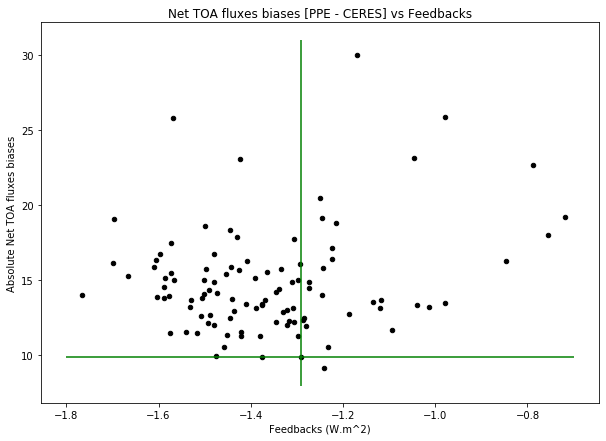

In [21]:
ax = plt.gca()
title = 'Net TOA fluxes biases [PPE - CERES] vs Feedbacks'
PPE_Bias_df.plot(kind='scatter', x='N', y='bias_N', color='black', figsize=(10, 7), 
                     style='.', ax = ax)
plt.hlines(Biases_official['bias_N'],xmin = -1.8,xmax = -0.7,label='official simulation', colors='green', 
           linestyles='solid')
plt.vlines(Feedbacks_official,ymin = 8,ymax = 31,label='official simulation', colors='green', 
           linestyles='solid')
#plt.plot(X_test, y_pred, color='blue', linewidth=1.0)

plt.xlabel('Feedbacks (W.m^2)')
plt.ylabel('Absolute Net TOA fluxes biases')
plt.title(title)
plt.show()

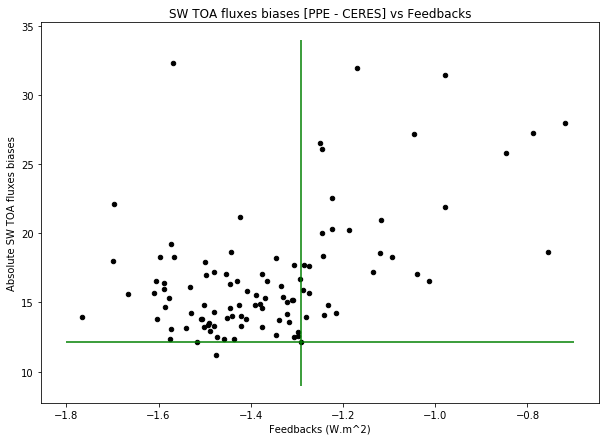

In [22]:
ax = plt.gca()
title = 'SW TOA fluxes biases [PPE - CERES] vs Feedbacks'
PPE_Bias_df.plot(kind='scatter', x='N', y='bias_SW', color='black', figsize=(10, 7), 
                     style='.', ax = ax)
plt.hlines(Biases_official['bias_SW'],xmin = -1.8,xmax = -0.7,label='official simulation', colors='green', 
           linestyles='solid')
plt.vlines(Feedbacks_official,ymin = 9,ymax = 34,label='official simulation', colors='green', 
           linestyles='solid')

plt.xlabel('Feedbacks (W.m^2)')
plt.ylabel('Absolute SW TOA fluxes biases')
plt.title(title)
plt.show()

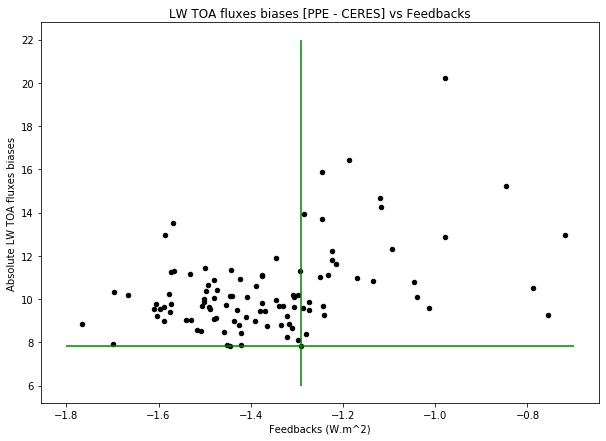

In [23]:
ax = plt.gca()
title = 'LW TOA fluxes biases [PPE - CERES] vs Feedbacks'
PPE_Bias_df.plot(kind='scatter', x='N', y='bias_LW', color='black', figsize=(10, 7), 
                     style='.', ax = ax)
plt.hlines(Biases_official['bias_LW'],xmin = -1.8,xmax = -0.7,label='official simulation', colors='green', 
           linestyles='solid')
plt.vlines(Feedbacks_official,ymin = 6,ymax = 22,label='official simulation', colors='green', 
           linestyles='solid')

plt.xlabel('Feedbacks (W.m^2)')
plt.ylabel('Absolute LW TOA fluxes biases')
plt.title(title)
plt.show()